# Test Inspektor Gadget scaling

The goal of this experiment is to test until which number of nodes Inspektor Gadget scales and to also collect its CPU usage.

## Experimental environment

### Hardware environment

Inspektor Gadget will be tested on an AKS cluster using `Standard_D16s_v5` as node Azure image (*i.e* 16 CPU cores and 64 GB of DRAM).
The number of nodes will vary over the experience with the following values: 2, 12, 25, 37 and 50.

### Software environment

AKS runs kubernetes 1.25 and relies on kernel 5.15.

To test scaling, the idea is to deploy a pod on each node which will generate a lot of `exec()` and to count the number of `exec()` events reported by Inspektor Gadget.
So, on each node, a pod running `stress-ng` is deployed to generate as many `exec()` it can during 1 second on all the node CPU (in our case 2).
Before that, Inspektor gadget is deployed on the cluster to monitor all these pods (which belong to the same namespace).

### Performance statistics

For each number of node, the above experiment is run 30 times to compute some statistics.

### Resource statistics

For each Inspektor Gadget pod, we will collect the following statistics:

1. The whole CPU usage in microseconds, before the experiment is run.
2. The whole CPU usage in microseconds, after the experiment is run.
3. The current memory footprint in bytes, after the experiment is run.

All these statistics are collected using `cgroupv2` `cpu.stat` and `memory.current` file.
By substracting the CPU usage after to the CPU usage before, we would get the CPU usage for the experiment.
Note that, this is not possible to get the peak memory footprint, as `memory.peak` is only available in kernel 5.19.

## Results

### Scaling results

The results are depicted in the following graphs.
The `x` axis indicates the experiment number from 1 to 30 while the `y` axis indicates the number of `exec()`.
Each graph presents two curves:

1. One which is the sum of all `exec()` generated for all nodes.
2. The other which is the number of `exec()` reported by Inspektor Gadget.

The situation is perfect when both curves overlap.

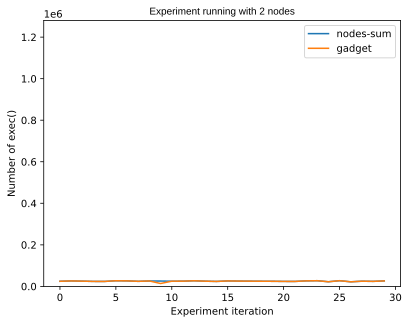

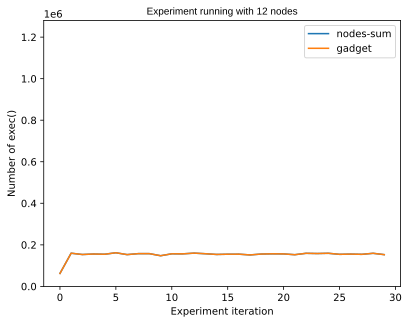

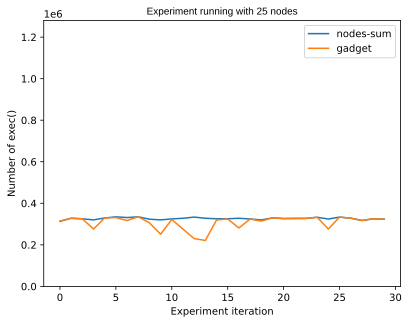

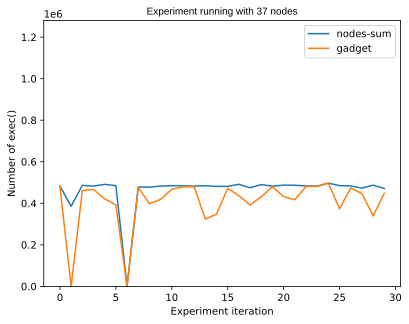

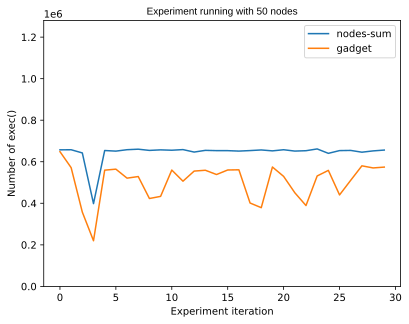

In [7]:
!pip install pandas > /dev/null
!pip install matplotlib --upgrade > /dev/null
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline


matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

NODE_NUMBERS = [2, 12, 25, 37, 50]
dataframes = []

for node_nr in NODE_NUMBERS:
    df = pd.read_csv(f'horizontal-16-10-23-16-12-21/exec-{node_nr}-nodes.csv')
    df['nodes-sum'] = df.filter(regex = 'node').sum(axis = 1)

    dataframes.append(df)

for i in range(len(NODE_NUMBERS)):
    dataframes[i][['nodes-sum', 'gadget']].plot()
    plt.title(f'Experiment running with {NODE_NUMBERS[i]} nodes', font='Liberation Sans')
    plt.xlabel('Experiment iteration')
    plt.ylabel('Number of exec()')
    plt.ylim(0, 1280000)
    plt.show()

### Interpretation

For 2 and 12 nodes, the curves are quite flat, so we can conclude there are not so much variation across the iterations.

Starting from 25 nodes, Inspektor Gadget begins to report less events than actually occuring.
There are also iterations where the number of generated events drops, which can be linked to a `stress-ng` pod failures.
As a consequence, there are a drop in reported events by Inspektor Gadget.

Let's compute the 99th percentile for all number of nodes:

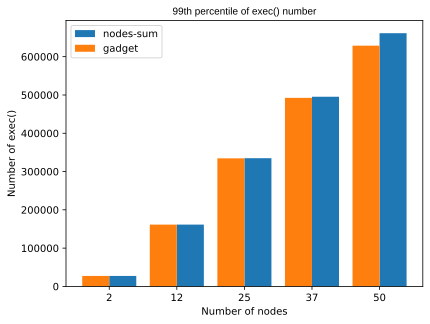

In [9]:
import numpy as np

percentiles = {'nodes-sum': [], 'gadget': []}

for i in range(len(NODE_NUMBERS)):
    # 99th percentile
    quantile = dataframes[i][['nodes-sum', 'gadget']].quantile(0.99)
    percentiles['nodes-sum'].append(quantile['nodes-sum'])
    percentiles['gadget'].append(quantile['gadget'])

df = pd.DataFrame(percentiles)
nodes_sum = df[['nodes-sum']].to_numpy().ravel()
gadget = df[['gadget']].to_numpy().ravel()

nodes_sum_fig = plt.bar(range(len(nodes_sum)), nodes_sum, align='edge', width=0.4, label='nodes-sum')
gadget_fig = plt.bar(range(len(gadget)), gadget, align='edge', width=-0.4, label='gadget')

plt.legend()
plt.xticks(np.arange(len(NODE_NUMBERS)), NODE_NUMBERS, rotation=0)
plt.xlabel('Number of nodes')
plt.ylabel('Number of exec()')
plt.title('99th percentile of exec() number', font='Liberation Sans')

plt.show()

With the 99th percentile, we can clearly see that Inspektor Gadget scales.
For 50 nodes, there is a difference of 32552 events which translates to an approximate 5%. 

Let's now take a look to the resource consumption of Inspektor Gadget.

### Resources results

As the result across different nodes are quite stable, we will only compute statistics over resource consumption on the experiment with 50 nodes.

Let's compute the 99th percentile of CPU usage during the stress, the memory footprint after the stress for each node and also over all nodes:

In [10]:
from IPython.display import display, Markdown

def to_sec(microsecond):
    return microsecond / 10 ** 6

def to_megabytes(bytes):
    return bytes / 1024 / 1024

nodes_nr = 50
dataframes = {}
quantiles = {}

# We need index_col = False because the CSV file contains a "," at the end of each line.
# This is not correct, but read_csv can handle it with this option.
df_cpu_before = pd.read_csv(f'horizontal-16-10-23-16-12-21/cpu-before-{node_nr}-nodes.csv', index_col=False).filter(regex = 'node')
df_cpu_after = pd.read_csv(f'horizontal-16-10-23-16-12-21/cpu-{node_nr}-nodes.csv', index_col=False).filter(regex = 'node')

dataframes['cpu'] = df_cpu_after - df_cpu_before
dataframes['memory'] = pd.read_csv(f'horizontal-16-10-23-16-12-21/memory-{node_nr}-nodes.csv', index_col=False).filter(regex = 'node')

for key in dataframes:
    quantiles[key] = dataframes[key].quantile(0.99)

markdown_array = ''
for node in quantiles['cpu'].index:
    memory = quantiles['memory'][node]
    cpu = quantiles['cpu'][node]
    
    markdown_array += f'|{node}|{to_sec(cpu):.2f}|{int(to_megabytes(memory))}|\n'

all_cpu = to_sec(quantiles['cpu'].quantile(0.99))
all_memory = int(to_megabytes(quantiles['memory'].quantile(0.99)))

markdown_array += f"|all nodes|{all_cpu:.2f}|{all_memory}|\n"
markdown_array = f"""
|node| CPU usage (s) | Memory footprint (MB) |
|----|----------------|-------------------------|
{markdown_array}
"""

display(Markdown(markdown_array))


|node| CPU usage (s) | Memory footprint (MB) |
|----|----------------|-------------------------|
|node-1|1.75|133|
|node-2|1.76|137|
|node-3|1.77|136|
|node-4|1.71|135|
|node-5|1.79|132|
|node-6|1.80|126|
|node-7|1.78|129|
|node-8|1.77|129|
|node-9|1.72|136|
|node-10|1.83|136|
|node-11|1.84|132|
|node-12|1.79|135|
|node-13|1.79|137|
|node-14|1.82|137|
|node-15|1.87|136|
|node-16|1.83|131|
|node-17|1.89|134|
|node-18|1.87|129|
|node-19|1.85|132|
|node-20|1.82|132|
|node-21|1.93|130|
|node-22|1.91|137|
|node-23|1.86|145|
|node-24|1.88|130|
|node-25|1.93|127|
|node-26|1.94|131|
|node-27|1.92|133|
|node-28|1.92|131|
|node-29|1.89|142|
|node-30|1.99|133|
|node-31|1.92|142|
|node-32|1.97|133|
|node-33|2.00|140|
|node-34|1.96|136|
|node-35|1.95|136|
|node-36|1.87|136|
|node-37|1.95|148|
|node-38|1.90|142|
|node-39|1.94|149|
|node-40|1.98|134|
|node-41|1.95|139|
|node-42|1.91|141|
|node-43|1.98|143|
|node-44|2.02|137|
|node-45|2.03|147|
|node-46|1.98|138|
|node-47|2.06|128|
|node-48|2.02|142|
|node-49|1.97|141|
|node-50|1.98|135|
|all nodes|2.04|148|



### Interpretation

As we can see, the 99th percentile CPU usage on all nodes is 2.04 seconds.
This number is higher than the duration of the experiment, which was one second.
This is totally normal and possible, as there the node has 2 CPU, so the whole time would be 2 seconds.

The memory fooprint is 148 MB, but it was collected at the end of the experiment when no gadget were working.

# Conclusion

To conclude, Inspektor Gadget scales until 50 nodes.
Its CPU usage may be high but this should be more investigated and its peak memory footprint will be collected once AKS support kernel 5.19.
Further investigation are nonetheless needed to tackle the cases where less events are reported.